# Milestone Project 1: Food Vision Big

## Get helper functions
In the past modeules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

In [2]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


ModuleNotFoundError: No module named 'tensorflow'

In [1]:
import sys
from contextlib import contextmanager

# Define a context manager to temporarily add a path to sys.path
@contextmanager
def temporary_sys_path_append(path):
    sys.path.append(path)  # Add the specified path to sys.path
    try:
        yield  # Allow code within the with-block to execute
    finally:
        # Ensure the path is removed after exiting the with-block
        sys.path.remove(path)

# Using the context manager to temporarily add a path to sys.path
with temporary_sys_path_append('..'):
    # Inside this block, you can import modules located in the added path
    from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
    # Use the function or perform actions with the imported module here

# Outside the with-block, the path is no longer in sys.path, limiting the change to the block

## Use TensorFlow Datasets to Download Data

In [2]:
# Get Tensorflow Datasets
import tensorflow_datasets as tdfs

In [3]:
# List all available datasets
datasets_list = tdfs.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list)

True


In [4]:
# Load in the data
(train_data, test_data), ds_info = tdfs.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they albel encoded)
* Do the labels match up with class names?

In [5]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [7]:
# Take one sample of the train data
train_one_sample = train_data.take(1) 
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 65
    Class name (str form): mussels
    


In [9]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 19,   6,   0],
        [ 29,  16,   8],
        [ 34,  21,  13],
        ...,
        [ 36,  19,   3],
        [ 35,  19,   3],
        [ 36,  20,   4]],

       [[ 20,   7,   0],
        [ 28,  15,   7],
        [ 34,  21,  13],
        ...,
        [ 37,  20,   4],
        [ 37,  20,   4],
        [ 37,  21,   5]],

       [[ 20,   7,   0],
        [ 25,  12,   4],
        [ 31,  18,  10],
        ...,
        [ 40,  21,   4],
        [ 40,  21,   4],
        [ 39,  22,   4]],

       ...,

       [[208, 206, 194],
        [209, 207, 195],
        [211, 209, 197],
        ...,
        [192, 196, 179],
        [190, 194, 177],
        [203, 207, 190]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [203, 207, 190],
        [211, 214, 197],
        [202, 205, 186]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [200, 204, 18

In [10]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

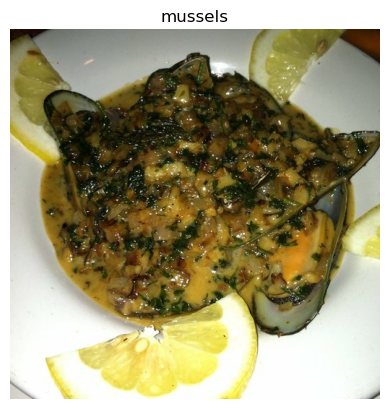

In [11]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image.numpy())
plt.title(class_names[label.numpy()])
plt.axis("off")
plt.show()

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all diferent sized tensors (different sized images)
* Not sclaed (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from `tf.keras.applications` we don't need to resclae our data (these architectures have rescaling built-in).

This means our functions needs to: 
1. Reshape our images to all the same size
2. Convert the dtype of our images tensors from `unit8` to `float32`

In [12]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image dtype from 'unit8' -> 'float32' and reshapes
    image to [img_shape, img_shape, colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

## Batch & prepare datasets

In [13]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [14]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data abd turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating modelling callbakcs

We're going to create a couple of callb acks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction.

In [16]:
# Create ModelChekpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [17]:
# Turn on mixed precision training 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [18]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [20]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [21]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Cheking layer dtype policies

In [23]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple putput layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [24]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                      validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240227-171926


Epoch 1/3
 837/2368 [=========>....................] - ETA: 3:32:50 - loss: nan - accuracy: 0.0105